<a href="https://colab.research.google.com/github/adityaharis69/0000001-afista.pratama/blob/main/Copy_of_Ki_67_segmentation_rev5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [2]:
# Install necessary libraries
!apt-get install openslide-tools
!pip install openslide-python
!pip install stardist

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 104 kB of archives.
After this operation, 297 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopenslide0 amd64 3.4.1+dfsg-5build1 [89.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 openslide-tools amd64 3.4.1+dfsg-5build1 [13.8 kB]
Fetched 104 kB in 1s (73.5 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-5build1) ...
Selecting previously unselected package openslide-tools

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import re
import csv
import json

from skimage import data, io, img_as_ubyte
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity
from tqdm import tqdm
from openslide import open_slide
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
from skimage.measure import regionprops_table

#Define parameter and folder path

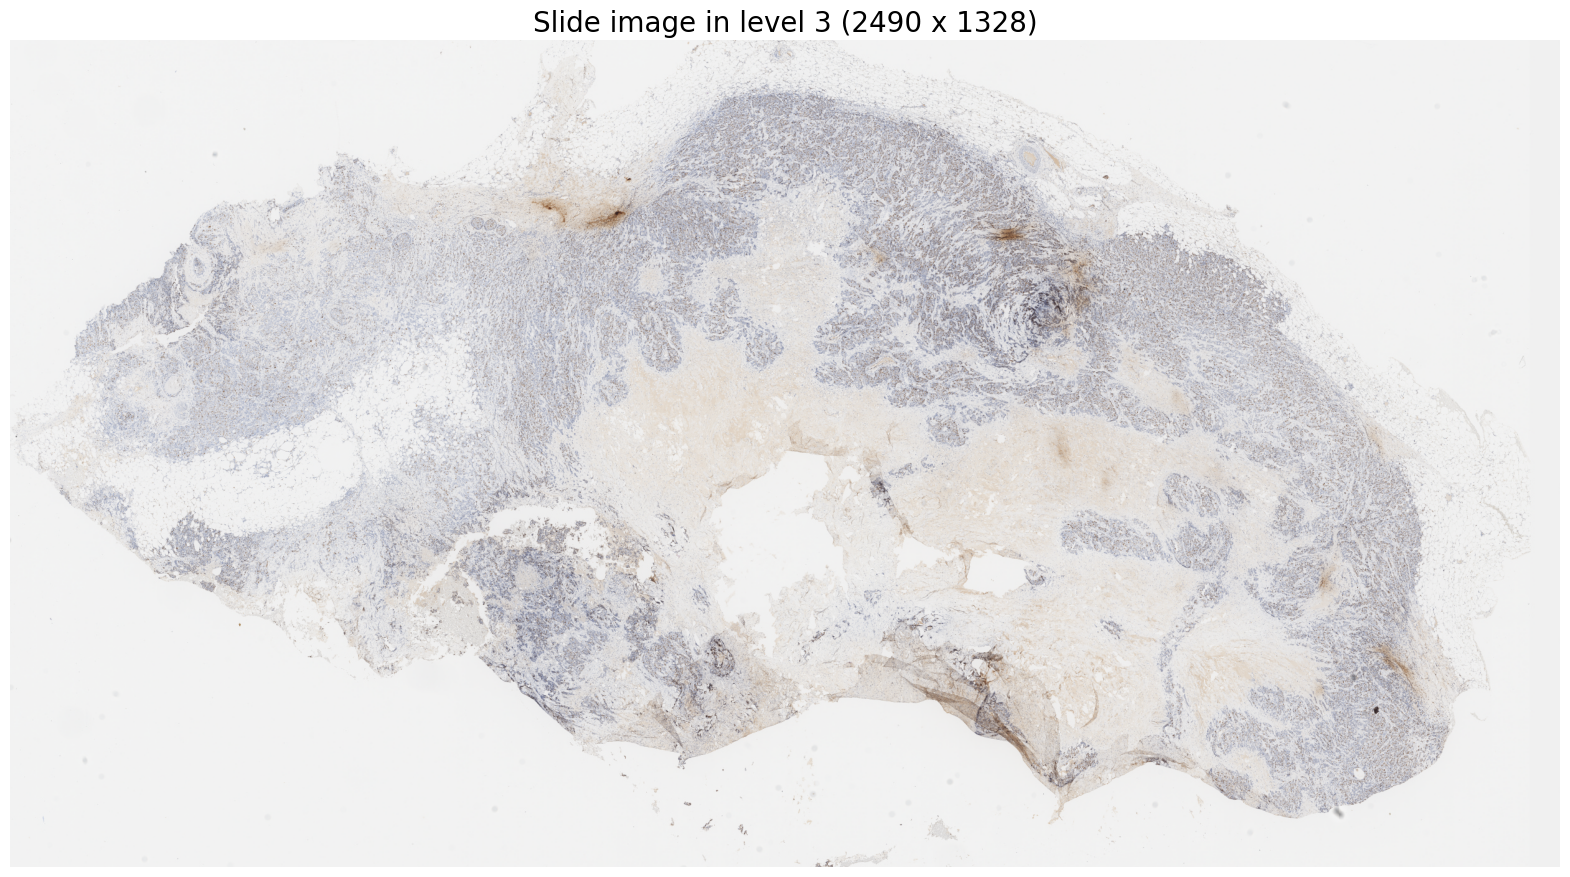

In [ ]:
# Specify the path to your SVS file
PROJECT_PATH = r'/content/drive/MyDrive/Projects'
CURRENT_PROJECT_NAME = 'Ki67'
SLIDE_NAME = '1002096.svs'

base_path = os.path.join(PROJECT_PATH, CURRENT_PROJECT_NAME)
svs_path = os.path.join(base_path, SLIDE_NAME)

# Open the SVS file using openslide
current_slide = open_slide(svs_path)

# display downloaded image in smallest level
slide_img = current_slide.read_region((0, 0), 3, current_slide.level_dimensions[3])
# Convert to RGB
# current_img_RGB = current_img.convert('RGB')
# convert to numpy
img_np = np.asarray(slide_img.convert('RGB'))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
plt.imshow(img_np)
plt.title("Slide image in level 3 (%d x %d)" % (current_slide.level_dimensions[3][0], current_slide.level_dimensions[3][1]), fontsize=20)
plt.axis('off')
plt.show()

In [ ]:
# Get the number of levels
# num_levels = current_slide.level_count

# Get information about each level
# for level in range(num_levels):
#     level_dimensions = current_slide.level_dimensions[level]
#     level_downsamples = current_slide.level_downsamples[level]

#     print(f"Level {level}:")
#     print(f"Dimensions: {level_dimensions}")
#     print(f"Downsample factor: {level_downsamples}")
#     print("----")

# Define parameters
LEVEL = 0  # Choose the resolution level
# tile_size = 512  # Specify the size of each tile
TILE_SIZE = 256  # Specify the size of each tile

# Get the dimensions of the WSI at the desired level
# width_at_level = current_slide.level_dimensions[level][0]
# height_at_level = current_slide.level_dimensions[level][1]
WIDTH, HEIGHT = current_slide.level_dimensions[LEVEL]

# Calculate the number of tiles in the horizontal and vertical directions
NUM_TILES_HOR = math.ceil(WIDTH / TILE_SIZE)
NUM_TILES_VER = math.ceil(HEIGHT / TILE_SIZE)

# Calculate the total number of tiles
# total_tiles = num_tiles_horizontal * num_tiles_vertical
print(f"\n\nTotal number of tiles around: {NUM_TILES_HOR * NUM_TILES_VER}")



Total number of tiles around: 52104


In [ ]:
# Extract the file name (excluding extension) from the SVS file path
# file_name = os.path.splitext(slide_name)[0]

# Create the output directory based on the file name
result_path = f'{base_path}/result'
folder_path = f'{base_path}/{os.path.splitext(SLIDE_NAME)[0]}'
goodtiles_path = f'{result_path}/goodtiles'
checkpoint_path = f'{result_path}/checkpoints'

# Create the output directory if it doesn't exist
os.makedirs(folder_path, exist_ok=True)
os.makedirs(goodtiles_path, exist_ok=True)
os.makedirs(checkpoint_path, exist_ok=True)
os.makedirs(result_path, exist_ok=True)

#Extract all tiles to the folder path

In [ ]:
# Function to save a tile
def save_tile(tile, tile_index, folder_path):
    tile_filename = f"tile_{tile[0]}_{tile[1]}.jpg"
    tile_filepath = os.path.join(folder_path, tile_filename)
    cv2.imwrite(tile_filepath, tile[2], [int(cv2.IMWRITE_JPEG_QUALITY), 95])  # Adjust JPEG quality as needed


# To extract a percentage of tiles
# tiles = []
tiles_generated = 0

for i in tqdm(range(0, current_slide.dimensions[0], TILE_SIZE), desc="Extracting Tiles", unit="image"):
    for j in range(0, current_slide.dimensions[1], TILE_SIZE):
        # Read a tile at the specified level
        tile = current_slide.read_region((i, j), LEVEL, (TILE_SIZE, TILE_SIZE))

        # Convert the tile to a NumPy array
        # tile_np = cv2.cvtColor(np.array(tile), cv2.COLOR_RGBA2RGB)
        tile_np = np.asarray(tile.convert('RGBA'));
        tile_img = cv2.cvtColor(tile_np, cv2.COLOR_RGBA2BGR)

        # Save the tile
        save_tile((i, j, tile_img), tiles_generated, folder_path)
        tiles_generated += 1

# Calculate and print the total number of tiles extracted
print()
print(f"Total number of tiles extracted: {tiles_generated}")

Extracting Tiles: 100%|██████████| 312/312 [38:48<00:00,  7.46s/image]


Total number of tiles extracted: 52104


#Filter Black, Blank, Partial, and Good Tiles with adjustable threshold

In [ ]:
# Set thresholds for mean and standard deviation
mean_threshold = 240
std_threshold = 10

# Lists to store different categories of tiles
good_tiles = []
partial_tiles = []
blank_tiles = []
black_tiles = []

# Variable to store the number of black images removed
total_black_removed = 0

# Function to calculate mean and standard deviation of an image
def calculate_mean_and_std(image):
    # Calculate mean and standard deviation
    mean_value = np.mean(image)
    std_value = np.std(image)

    return mean_value, std_value

# Function to remove mostly black images
def remove_blank_images(image, black_pixel_threshold=0.20):
    # Calculate the percentage of black pixels
    black_pixel_percentage = np.count_nonzero(image == 0) / image.size

    # Check if the image has a high percentage of black pixels
    if black_pixel_percentage >= black_pixel_threshold:
        #os.remove(tile_path)
        black_tiles.append(tile_filename)
        return True

    return False

# Iterate over the tiles in the folder with specified formats
for tile_filename in tqdm([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))], desc="Filtering Tiles", unit="Tiles"):
    # Read the tile
    tile_path = os.path.join(folder_path, tile_filename)
    tile = cv2.imread(tile_path, cv2.IMREAD_COLOR)

    if tile is None or tile.size == 0:
        print(f"Skipping empty image: {tile_path}")
        continue

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)

    # Remove mostly black images
    if remove_blank_images(gray_image):
        total_black_removed += 1
        continue

    # else:
    # Calculate mean and standard deviation of the tile
    mean_value, std_value = calculate_mean_and_std(gray_image)

    # Classify the tile based on mean and standard deviation
    if mean_value > mean_threshold and std_value < std_threshold:
        blank_tiles.append(tile_filename)
    elif mean_value < mean_threshold and std_value < std_threshold:
        partial_tiles.append(tile_filename)
    elif mean_value < mean_threshold and std_value > std_threshold:
        good_tiles.append(tile_filename)

# Save the filenames into text files with the total number of tiles in the title
with open(os.path.join(goodtiles_path, 'good_tiles.txt'), 'w') as file:
    file.write('\n'.join(good_tiles))

# Print the results
total_good_tiles = len(good_tiles)
total_partial_tiles = len(partial_tiles)
total_blank_tiles = len(blank_tiles)

print()
print(f"Total numbers of good tiles are:", total_good_tiles)
#print(f"Total numbers of partial tiles are:", total_partial_tiles)
#print(f"Total numbers of blank tiles are:", total_blank_tiles)
#print(f"Total numbers of black tiles removed:", total_black_removed)

NameError: name 'folder_path' is not defined

#Define the pretrained model with adjustable threshold

In [ ]:
# Close the WSI image
current_slide.close()

NameError: name 'current_slide' is not defined

In [ ]:
# Define a pretrained model to segment nuclei in fluorescence images (download from pretrained)

MODEL_NAME = '2D_demo'
THRESHOLD = 0.80

model = StarDist2D.from_pretrained(MODEL_NAME)
# if model_name != '2D_demo':
#     threshold = 0

print()
print(f'Using {MODEL_NAME} with threshold = {THRESHOLD}')

Found model '2D_demo' for 'StarDist2D'.
5298331/5298331 [==============================] - 0s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.

Using 2D_demo with threshold = 0.8


#Stain color separation

In [ ]:
# Separate the individual stains from the IHC image
def color_separate(ihc_rgb):

    #Convert the RGB image to HED using the prebuilt skimage method
    ihc_hed = rgb2hed(ihc_rgb)

    # Create an RGB image for each of the separated stains
    #Convert them to ubyte for easy saving to drive as an image
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = img_as_ubyte(hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1)))
    ihc_e = img_as_ubyte(hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1)))
    ihc_d = img_as_ubyte(hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1)))

    #Optional fun exercise of combining H and DAB stains into a single image with fluorescence look

    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 0], 99)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 2], 99)))

    # Cast the two channels into an RGB image, as the blue and green channels
    #Convert to ubyte for easy saving as image to local drive
    zdh = img_as_ubyte(np.dstack((null, d, h))) #DAB in green and H in Blue

    return (ihc_h, ihc_e, ihc_d, zdh)

#Segmentation process and the result

In [ ]:
# Initialize variables
D_total_area = 0
D_total_quantity = 0
H_total_area = 0
H_total_quantity = 0
images_displayed = 0
excluded_tiles = 0
total_samples = 20
probability = 0.004

all_centroids_and_bboxes = []

# Directory containing image files
all_files = os.listdir(goodtiles_path)

# Filter files that start with "good_tiles_"
good_tiles_files = [file for file in all_files if file.startswith("good_tiles")]

# Check if there is a segmented.csv file and load processed tiles]
csv_filename = f"Segmentation-{LEVEL}-{TILE_SIZE}-{MODEL_NAME}-{THRESHOLD:.2f}.csv"
segmented_csv_path = os.path.join(checkpoint_path, csv_filename)
processed_tiles = {}

if os.path.exists(segmented_csv_path) and os.stat(segmented_csv_path).st_size != 0:
    with open(segmented_csv_path, 'r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader, None)  # Skip header if file is not empty
        processed_tiles = {row[0]: row[1:] for row in csv_reader}

# Remove rows with all zeros
keys_to_remove = []
for filename, values in processed_tiles.items():
    if all(value == '0' or value == 0 for value in values):
        print(f"Found {filename} is containing all zero values.")
        keys_to_remove.append(filename)

# Remove the rows after iteration
for key in keys_to_remove:
    del processed_tiles[key]

# Check if the process is starting fresh or resuming from the last checkpoint
if processed_tiles:
    print("Resuming from the last checkpoint.")
    # Iterate over each "good_tiles_" file
    for good_tiles_file in good_tiles_files:
        # Read image names from the "good_tiles_" file
        good_tiles_file_path = os.path.join(goodtiles_path, good_tiles_file)
        with open(good_tiles_file_path, 'r') as file:
            good_tile_filenames = file.read().splitlines()

        # Exclude tiles that have already been processed
        excluded_tiles += sum(1 for filename in good_tile_filenames if filename in processed_tiles)
        # Display the number of excluded tiles
        print(f"There are {excluded_tiles} tiles already segmented.")
else:
    print(f"Starting fresh. Creating File: {csv_filename}")

# Open the segmented.csv file in append mode to write new data
with open(segmented_csv_path, 'a', newline='') as file:
    csv_writer = csv.writer(file)

    # Write the header if the file is empty
    if file.tell() == 0:
        csv_writer.writerow(['Filename', 'D_total_area', 'H_total_area', 'D_total_quantity', 'H_total_quantity'])

    # Iterate over each "good_tiles_" file and process images
    for good_tiles_file in good_tiles_files:
        # Read image names from the "good_tiles_" file
        good_tiles_file_path = os.path.join(goodtiles_path, good_tiles_file)
        with open(good_tiles_file_path, 'r') as file:
            good_tile_filenames = file.read().splitlines()

        # Process images using the specified image names
        for filenames in tqdm(good_tile_filenames, desc="Segmenting Tiles", unit="Tiles"):
            if filenames in processed_tiles:
                continue

            tile_path = os.path.join(folder_path, filenames)

            ihc_rgb = io.imread(tile_path)
            H, E, D, HD = color_separate(ihc_rgb)

            H_img = np.invert(H[:, :, 2])
            D_img = np.invert(D[:, :, 2])

            D_labels, D_details = model.predict_instances(normalize(D_img), prob_thresh=THRESHOLD)
            H_labels, H_details = model.predict_instances(normalize(H_img), prob_thresh=THRESHOLD)

            D_props = regionprops_table(D_labels, D_img,
                                        properties=['label', 'centroid', 'bbox',
                                                    'area', 'equivalent_diameter',
                                                    'mean_intensity', 'solidity'])
            D_analysis_results = pd.DataFrame(D_props)

            H_props = regionprops_table(H_labels, H_img,
                                        properties=['label', 'centroid', 'bbox',
                                                    'area', 'equivalent_diameter',
                                                    'mean_intensity', 'solidity'])
            H_analysis_results = pd.DataFrame(H_props)

            D_total_quantity = len(D_analysis_results)
            H_total_quantity = len(H_analysis_results)

            D_total_area = D_analysis_results["area"].sum()
            H_total_area = H_analysis_results["area"].sum()

            # retreive centroid data
            D_centroid_result = D_analysis_results[['centroid-0', 'centroid-1']]
            D_centroids = [tuple((x, y)) for y, x in D_centroid_result.values.tolist()]
            # D_bbox = D_analysis_results[['bbox-0', 'bbox-1', 'bbox-2', 'bbox-3']]

            H_centroid_result = H_analysis_result[['centroid-0', 'centroid-1']]
            H_centroids = [tuple((x, y)) for y, x in H_centroid_result.values.tolist()]
            # H_bbox_lst = H_analysis_results[['bbox-0', 'bbox-1', 'bbox-2', 'bbox-3']]

            all_centroids_and_bboxes.append({'filename': filenames, 'H-centroids': H_centroids, 'D-centroid': D_centroids})


            if images_displayed < total_samples and random.random() <= probability:
                fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

                # Row 1
                axes[0, 0].imshow(ihc_rgb)
                axes[0, 0].set_title('Real Image')

                axes[0, 1].imshow(H)
                axes[0, 1].set_title('H Separated')

                for centroid_H in H_centroids:
                    x0 = int(centroid_H[0])
                    y0 = int(centroid_H[1])
                    cv2.circle(H, (x0, y0), 5, (255, 0, 0), -1)

                axes[0, 2].imshow(H)
                axes[0, 2].set_title('H Detected')

                axes[0, 3].imshow(render_label(H_labels, img=H_img))
                axes[0, 3].set_title('H Segmented')

                # Row 2
                axes[1, 0].imshow(ihc_rgb)
                axes[1, 0].set_title('Real Image')

                axes[1, 1].imshow(D)
                axes[1, 1].set_title('D Separated')

                for centroid_D in D_centroids:
                    x0 = int(centroid_D[0])
                    y0 = int(centroid_D[1])
                    cv2.circle(D, (x0, y0), 5, (0, 0, 255), -1)

                axes[1, 2].imshow(D)
                axes[1, 2].set_title('D Detected')

                axes[1, 3].imshow(render_label(D_labels, img=D_img))
                axes[1, 3].set_title('D Segmented')

                # Add a main title
                title = f'{filenames[:-4]}'
                plt.suptitle(title, fontsize=20)

                # Turn off axis for all subplots
                for ax in axes.flatten():
                    ax.axis('off')

                # Add a border around the entire figure
                fig.patch.set_edgecolor('black')
                fig.patch.set_linewidth(4)

                # Create a sanitized version of the title for the filename
                sanitized_title = re.sub(r'[^\w\s.-]', '', title)

                # Save the plot layout to a file with a sanitized title and a valid file format
                sample_path = f"{result_path}/samples/Samples-{LEVEL}-{TILE_SIZE}-{MODEL_NAME}-{THRESHOLD:.2f}"
                os.makedirs(sample_path, exist_ok=True)

                plot_layout_path = os.path.join(sample_path, f'{sanitized_title}.png')
                plt.savefig(plot_layout_path, bbox_inches='tight')
                print()
                print(f"Segmented plot saved to: {plot_layout_path}")

                plt.show()

                images_displayed += 1

            # Write the segmented results to the csv file
            csv_writer.writerow([filenames, D_total_area, H_total_area, D_total_quantity, H_total_quantity])

            # Update the dictionary of processed tiles
            processed_tiles[filenames] = [D_total_area, H_total_area, D_total_quantity, H_total_quantity]

# Write centroid and bbox data to the json file
with open(os.path.join(checkpoint_path, f'{os.path.splitext(SLIDE_NAME)[0]}_centroids.json'), 'w') as out:
    json.dump(all_centroids_and_bboxes, out)

print()
print(f"Segmentation process completed.")

NameError: name 'os' is not defined

In [ ]:
# Initialize variables to store the sum of quantities and areas
D_all_quantity_sum = 0
H_all_quantity_sum = 0
D_all_area_sum = 0
H_all_area_sum = 0

# Define the file path
sum_filename = f"Segmentation-0-256-2D_demo-0.80.csv"
segmented_csv_path = os.path.join(checkpoint_path, sum_filename)

# Check if the file exists
if os.path.exists(segmented_csv_path):
    # Read the CSV file
    df = pd.read_csv(segmented_csv_path)

    # Check if the necessary columns exist
    required_columns = ['D_total_area', 'H_total_area', 'D_total_quantity', 'H_total_quantity']

    if all(column in df.columns for column in required_columns):
        # Sum up the values for each column
        D_all_area_sum = df['D_total_area'].sum()
        D_all_quantity_sum = df['D_total_quantity'].sum()
        H_all_area_sum = df['H_total_area'].sum()
        H_all_quantity_sum = df['H_total_quantity'].sum()

        # Calculate percentages and print the results
        results = []
        results.append(f"Filename: {sum_filename}")
        results.append("----")
        results.append("AREA SEGMENTATION")
        results.append("Segmentation Areas for all D: {:,} px²".format(D_all_area_sum))
        results.append("Segmentation Areas for all H: {:,} px²".format(H_all_area_sum))
        positivity = (D_all_area_sum / (D_all_area_sum + H_all_area_sum)) * 100
        results.append("Detected Area of all DAB is: {:.2f}%".format(positivity))
        results.append("----")
        results.append("QUANTITY SEGMENTATION")
        results.append("Segmentation Quantity for all D: {:,} dots".format(D_all_quantity_sum))
        results.append("Segmentation Quantity for all H: {:,} dots".format(H_all_quantity_sum))
        quantity = (D_all_quantity_sum / (D_all_quantity_sum + H_all_quantity_sum)) * 100
        results.append("Detected Quantity of all DAB is: {:.2f}%".format(quantity))

        # Print results to the prompt
        for line in results:
            print(line)

        # Save results to a text file in the specified result path
        text_filename = os.path.splitext(sum_filename)[0]
        result_file_path = os.path.join(result_path, f"{text_filename}.txt")
        with open(result_file_path, "w") as file:
            for line in results:
                file.write(line + "\n")
        print(f"----")
        print(f"The results saved in {result_file_path}")
    else:
        print(f"The required columns are not present in the CSV file.")
else:
    print(f"The specified file does not exist.")

Filename: Segmentation-0-256-2D_demo-0.80.csv
----
AREA SEGMENTATION
Segmentation Areas for all D: 66,450,144 px²
Segmentation Areas for all H: 134,130,676 px²
Detected Area of all DAB is: 33.13%
----
QUANTITY SEGMENTATION
Segmentation Quantity for all D: 90,684 dots
Segmentation Quantity for all H: 193,347 dots
Detected Quantity of all DAB is: 31.93%
----
The results saved in /content/drive/MyDrive/Projects/Ki67/result/Segmentation-0-256-2D_demo-0.80.txt


In [4]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
